# HMM inference and MAP estimation in Gilbert-Elliot channel model 
## TensorFlow implementation of classical HMM and the parallel version.

This notebook implements the algorithms from Ref.[2]

[2] S. S. Hassan, S. Särkkä and Á. F. García-Fernández (2021). __Temporal Parallelization of Inference in Hidden Markov Models__. *__IEEE Transactions on Signal Processing__*, Volume: 69, Pages 4875-4887. DOI: [10.1109/TSP.2021.3103338](https://doi.org/10.1109/TSP.2021.3103338)



### Imports and utilities

In [39]:
# Python specific imports that will make our job easier and our code prettier
from collections import namedtuple
from functools import partial
import math
import time
from tqdm.auto import trange, tqdm

# TF specific imports that we will use to code the logic
from tensorflow import function
import tensorflow as tf
import tensorflow_probability as tfp

# Auxiliary libraries that we will use to report results and create the data
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

# Utilities
mm = tf.linalg.matmul
mv = tf.linalg.matvec

# device = '/TPU:0'
device = '/GPU:0'

# check if device is available
# tf.test.is_gpu_available()

### Model

We consider the Gilbert-Elliot channel model. This is  a classical model used in the transmission of signals in digital communication channels. We consider two inputs: one for input signal and another for channel regime signal. They are binary signals and represented by $b_k$ and $s_k$, respectively. 

The input signal $b_k$ is flipped by an idependendent error. We can model this as 
$$
y_k = b_k \oplus v_k
$$

The regime channel signal $s_k$ is represented as two states hidden Markov model, which can have either a good or a bad channel condition. The good state has a low probability error, while the bad state can have a high probability error. If $v_k = 1$ i.e. an error occurs, where $y_k \neq b_k$, then

- $q_0$ represents the probability of the error in the good state.
- $q_1$ represents the probability of the error in the bad state.

The transition probability can be represented as

- $p_0$: transition from high error state (bad state) to low error state (good state).
- $p_1$: transition from low error state (good state) to high error state (bad state).
- $p_2$: switching probability of $b_k$.

The joint model $x_k = (s_k, b_k)$ is a four-state Markov chain. That is,
$$
x_k = \{(0, 0), (0, 1), (1, 0), (1, 1)\}
$$ 
and encoded as $\{0, 1, 2, 3\}$. Our transition and observation matrices are as follows:


$$
\Pi = p(x_k \mid x_{k-1}) = \begin{pmatrix}
(1 - p_0)(1 - p_2) & p_0 (1 - p_2)   & (1 - p_0)p_2        & p_0 p_2 \\  
p_1 (1 - p_2)      & (1-p_1) (1-p_2) & p_1 p_2             & (1- p_1) p_2 \\
(1 - p_0)          & p_0 p_2         & (1 - p_0) (1 - p_2) & p_0  (1 - p_2) \\
p_1 p_2            & (1 - p_1)p_2    & p_1 (1 - p_2)       & (1 - p_1) (1 - p_2)
\end{pmatrix}
$$

and

$$
O = p(y_k\mid x_k) = \begin{pmatrix}
(1 - q_0) & q_0 \\
(1 - q_1) & q_1 \\
q_0 & (1 - q_0) \\
q_1 & (1 - q_1)
\end{pmatrix}
$$





In [2]:
class HMMModel:
    def __init__(self, p0=0.03,  p1=0.1, p2=0.05, q0=0.01, q1=0.1):
        """Gilbert-Elliot channel model.
        
        :math:``
            p0: `P(S_{k+1} = 1 | S_{k} = 0)`
            p1: `P(S_{k+1} = 0 | S_{k} = 1)`
            p2: `P(B_{k+1} = 1 | B_{k} = 0) = P(B_{k+1} = 0 | B_{k} = 1)`
            q0: `P(Y_k != b | B_k = b, S_k = 0)`
            q1: `P(Y_k != b | B_k = b, S_k = 1)`
        
        """
        # transition matrix
        self.np_Pi = np.array([
            [(1-p0)*(1-p2), p0*(1-p2),     (1-p0)*p2,     p0*p2],
            [p1*(1-p2),     (1-p1)*(1-p2), p1*p2,         (1-p1)*p2],
            [(1-p0)*p2,     p0*p2,         (1-p0)*(1-p2), p0*(1-p2)],
            [p1*p2,         (1-p1)*p2,     p1*(1-p2),     (1-p1)*(1-p2)]
        ])
        
        # observation matrix
        self.np_Po = np.array([
            [(1-q0), q0],
            [(1-q1), q1],
            [q0, (1-q0)],
            [q1, (1-q1)]
        ])

        # prior
        self.np_prior = np.array([0.25, 0.25, 0.25, 0.25])

        # convert to tensor
        self.Pi    = tf.convert_to_tensor(self.np_Pi)
        self.Po    = tf.convert_to_tensor(self.np_Po)
        self.prior = tf.convert_to_tensor(self.np_prior)
        
        # dimensions
        self.Pi_dim = self.np_Pi.shape[-1]
        self.Po_dim = self.np_Po.shape[-1]
        self.prior_dim = self.np_prior.shape[-1]

        # transition, observation, and prior in log-space
        self.log_Pi    = tf.math.log(self.np_Pi)
        self.log_Po    = tf.math.log(self.np_Po)
        self.log_prior = tf.math.log(self.np_prior)


In [3]:
def catrnd(rng, p):
    if p.ndim > 1:
        p = p.squeeze()
    
    return rng.choice(p.shape[0], size=1,  p=p)

def simulate_data(model: HMMModel, steps:int, seed:int=1):
    rng = np.random.default_rng(seed)
    
    X = np.zeros((steps, 1))
    Y = np.zeros(steps, dtype=np.int32)
    x = catrnd(rng, model.np_prior)
    
    for k in range(steps):
        if k > 0:
            x = catrnd(rng, model.np_Pi[x])
        y = catrnd(rng, model.np_Po[x])
        X[k] = x
        Y[k] = y
    
    return X, Y


#### Initialize the parameters

In [4]:
log10T = 5
nsteps = 100
T = np.arange(10 ** log10T)+1

#### Initiate the model

In [5]:
model = HMMModel()

#### Simulate the data

In [6]:
X,Y = simulate_data(model,10 ** log10T)

#### Plot the simulated data

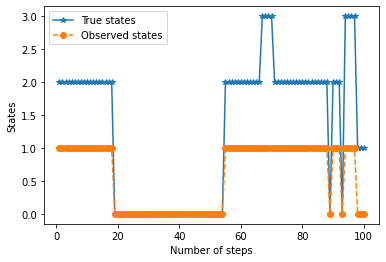

In [7]:
plt.plot(T[:nsteps], X[:nsteps], '*-', T[:nsteps], Y[:nsteps], 'o--')
plt.xlabel('Number of steps')
plt.ylabel('States')
plt.legend(['True states', 'Observed states'])

### Sequential Bayesian filter and smoother



#### Filter routine

In [8]:
@tf.function
def bayesian_filter(model, obs):
    """A sequential bayesian filter routine
    Parameters
    ----------
    model: 
        HMM model
    obs: array_like
        Observations
    Returns
    -------
    bayes_fs: 
        filtering estimates
        
    """
    def body(carry, y):    
        k, p = carry # k is the iteration
        p = tf.cond(k > 0, lambda: mv(model.Pi, p, transpose_a=True), lambda: p)
        p = model.Po[:, y] * p
        p = p / tf.reduce_sum(p)
        return (k+1, p)

    ks, bayes_fs = tf.scan(body, obs, (0, model.prior))
    return bayes_fs

Smoother routine

In [9]:
@tf.function
def bayesian_smoother(model, bayes_fs):
    """A sequential Bayesian smoother routine

    Parameters
    ----------
    model: 
        HMM model
    bayes_fs: array_like
        filtering estimates
    Returns
    -------
    bayes_ss: 
        smoothing estimates
    """
    def body(carry, fest):
        p = carry
        festp = mv(model.Pi, fest, transpose_a=True)
        p = fest * mv(model.Pi, p / festp)
        p = p / tf.reduce_sum(p)
        return p
  
    bayes_ss = tf.scan(body, bayes_fs[:-1], bayes_fs[-1], reverse=True)
    bayes_ss = tf.concat([bayes_ss, tf.expand_dims(bayes_fs[-1], 0)], 0)
    return bayes_ss



 #### Sequential Bayesian filter and smoother routine combined

In [10]:
@tf.function
def bayesian_filter_smoother(model, obs):
    """A combined sequential Bayesian filter smoother routine

    Parameters
    ----------
    model: 
        HMM model
    obs: array_like
        observations
    Returns
    -------
    bayes_fs:
        filtering estimates
    bayes_ss: 
        smoothing estimates
    """
    bayes_fs = bayesian_filter(model, obs)
    bayes_ss = bayesian_smoother(model, bayes_fs)
    return bayes_fs, bayes_ss

### Plot sequential Bayesian filter-smoother and compare with reference

In [11]:
with tf.device('/CPU:0'):
    bayes_fs = bayesian_filter(model, Y)
    bayes_ss = bayesian_smoother(model, bayes_fs)


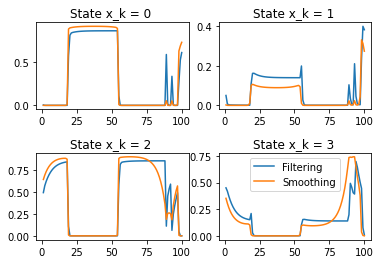

In [12]:
plt.clf()
plt.subplots_adjust(hspace=.5)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(T[:nsteps], [p[i] for p in bayes_fs[:nsteps]], T[:nsteps], [p[i] for p in bayes_ss[:nsteps]])
    
    plt.title(('State x_k = %d ' % i ))    
plt.legend(['Filtering', 'Smoothing'])
plt.show()


### Utilities for log-space computations




In [13]:
@tf.function
def log_mv(log_A, log_b, transpose_a=False):
    Amax = tf.reduce_max(log_A, axis=(-1, -2), keepdims=True)
    bmax = tf.reduce_max(log_b, axis=(-1), keepdims=True)
    return tf.squeeze(Amax, axis=-1) + bmax + tf.math.log(mv(tf.math.exp(log_A - Amax), tf.math.exp(log_b - bmax), transpose_a=transpose_a))

@tf.function
def semilog_mv(A, log_b, transpose_a=False):
    bmax = tf.reduce_max(log_b, axis=(-1), keepdims=True)
    return bmax + tf.math.log(mv(A, tf.math.exp(log_b - bmax), transpose_a=transpose_a))

@tf.function
def log_mm(log_A, log_B,transpose_a=False, transpose_b=False):
    Amax = tf.reduce_max(log_A, axis=(-1,-2), keepdims=True)
    Bmax = tf.reduce_max(log_B, axis=(-1,-2), keepdims=True)
    return Amax + Bmax + tf.math.log(mm(tf.math.exp(log_A - Amax), tf.math.exp(log_B - Bmax), transpose_a=transpose_a, transpose_b=transpose_b))

@tf.function
def log_normalize(log_p):
    pmax = tf.reduce_max(log_p, axis=(-1), keepdims=True)
    temp = tf.math.exp(log_p - pmax)
    return tf.math.log(temp / tf.reduce_sum(temp, axis=-1, keepdims=True))

print('Test utility functions:')
with tf.device('/CPU:0'):
    tf.random.set_seed(5)
    A = tf.random.uniform(shape=[4, 4])
    B = tf.random.uniform(shape=[4, 4])
    log_A = tf.math.log(A)
    log_B = tf.math.log(B)
    print(mm(A, B))
    print(tf.math.exp(log_mm(log_A, log_B)))

    b = tf.random.uniform(shape=[4])
    log_b = tf.math.log(b)
    print(mv(A, b))
    print(tf.math.exp(log_mv(log_A, log_b)))
    print(tf.math.exp(semilog_mv(A, log_b)))

    print(b / tf.reduce_sum(b, keepdims=True))
    print(tf.math.exp(log_normalize(log_b)))


Test utility functions:
tf.Tensor(
[[1.4257064  1.0391585  0.7607688  1.0484284 ]
 [0.9447347  0.76951545 0.44059256 0.6164023 ]
 [0.35811597 0.34018368 0.16159499 0.33705997]
 [0.75753486 0.5810969  0.41004145 0.6656992 ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[1.4257064  1.0391583  0.7607688  1.0484283 ]
 [0.94473475 0.76951534 0.44059253 0.61640227]
 [0.35811597 0.3401837  0.161595   0.33705997]
 [0.75753486 0.58109677 0.41004142 0.6656991 ]], shape=(4, 4), dtype=float32)
tf.Tensor([0.5768026  0.33639905 0.15708235 0.353592  ], shape=(4,), dtype=float32)
tf.Tensor([0.5768026  0.33639905 0.15708235 0.35359204], shape=(4,), dtype=float32)
tf.Tensor([0.5768026  0.3363991  0.15708235 0.35359204], shape=(4,), dtype=float32)
tf.Tensor([0.19298144 0.3319118  0.0531239  0.42198285], shape=(4,), dtype=float32)
tf.Tensor([0.19298144 0.3319118  0.0531239  0.42198288], shape=(4,), dtype=float32)


### Log-space sequential Bayesian filter and smoother

#### Filter routine

In [14]:
@tf.function
def log_bayesian_filter(model, obs):
    """A bayesian filter routine in log space
    
    Parameters
    ----------
    model: 
        HMM model
    obs: array_like
        observations
    Returns
    -------
    log_bayes_fs: 
        filtering estimates
    """
    def body(carry, y):    
        k, log_p = carry # k is the iteration
        log_p = tf.cond(k > 0, lambda: semilog_mv(model.Pi, log_p, transpose_a=True), lambda: log_p)
        log_p = model.log_Po[:, y] + log_p
        log_p = log_normalize(log_p)
        return (k+1, log_p)

    ks, log_bayes_fs = tf.scan(body, obs, (0, model.log_prior))
    return log_bayes_fs


#### Smoother routine

In [15]:
@tf.function
def log_bayesian_smoother(model, log_bayes_fs):
    """A bayesian smoother routine in log space
    Parameters
    ----------
    model: 
        HMM model
    log_bayes_fs: array_like
        filtering estimates
    Returns
    -------
    log_bayes_ss: 
        smoothing estimates
    """
    def body(carry, log_fest):
        log_p = carry
        log_festp = semilog_mv(model.Pi, log_fest, transpose_a=True)
        log_p = log_fest + semilog_mv(model.Pi, log_p - log_festp)
        log_p = log_normalize(log_p)
        return log_p
  
    log_bayes_ss = tf.scan(body, log_bayes_fs[:-1], log_bayes_fs[-1], reverse=True)
    log_bayes_ss = tf.concat([log_bayes_ss, tf.expand_dims(log_bayes_fs[-1], 0)], 0)
    return log_bayes_ss


#### Log Bayesian Filter and Smoother routines

In [16]:
@tf.function
def log_bayesian_filter_smoother(model, obs, max_parallel=0):
    log_bayes_fs = log_bayesian_filter(model, obs)
    log_bayes_ss = log_bayesian_smoother(model, log_bayes_fs)
    return log_bayes_fs, log_bayes_ss


#### Test classical and log-space Bayesian filters and smoothers

In [17]:
with tf.device('/CPU:0'):
    plain_bayes_fs,plain_bayes_ss = bayesian_filter_smoother(model, Y)
    log_bayes_fs,log_bayes_ss     = log_bayesian_filter_smoother(model, Y)
    print('Difference between classical and log-space Bayesian filters: ', np.abs(plain_bayes_fs - tf.math.exp(log_bayes_fs)).max())
    print('Difference between classical and log-space Bayesian smoothers: ', np.abs(plain_bayes_ss - tf.math.exp(log_bayes_ss)).max())
    print('Is log space result NaN?', tf.math.is_nan(tf.reduce_mean(log_bayes_ss)))

Difference between classical and log-space Bayesian filters:  6.661338147750939e-16
Difference between classical and log-space Bayesian smoothers:  8.881784197001252e-16
Is log space result NaN? tf.Tensor(False, shape=(), dtype=bool)


We have Sequential Bayesian filter and smoother as a baseline. Now, we implement a parallel version of this. The parallel version is similar to Algorithm 3 described in the paper. However, there are differences with potential-based (See phmm_potentials.ipynb notebook). First, here we consider filtering and smoothing distribution. Moreover, we consider RTS type smoothers. 

### Parallel Bayesian filter and smoother

#### Filter initialization routine:

In [18]:
@tf.function
def pbayesian_filter_init_first(model, y):
    """A Bayesian filter initialize routine to initialize first element.

    Parameters
    ----------
    model: 
        HMM model
    y: array_like
        observations
    Returns
    -------
    f: type
        description
    g: type
        description
    """
    pxy = model.Po[:, y] * model.prior
    py  = tf.reduce_sum(pxy)
    pxy = pxy / py
    f = pxy * tf.ones_like(model.Pi)
    g = py  * tf.ones_like(model.prior)
    return f, g

@tf.function
def pbayesian_filter_init_rest(model, obs):
    """A Bayesian filter initialize routine to initialize the rest of the elements

    Parameters
    ----------
    model: 
        HMM model
    y: array_like
        observations
    Returns
    -------
    f: type
        description
    g: type
        description
    
    """
    temp = tf.gather(tf.transpose(model.Po), obs, axis=0)
    pxy = tf.expand_dims(temp, 1) * tf.expand_dims(model.Pi, 0)
    g = tf.reduce_sum(pxy, axis=2)
    f = pxy / g[..., None]
    return f, g

@tf.function
def pbayesian_filter_init(model, obs):
    """A Bayesian filter initialize routine combine the first and generic elements
    
    """
    
    first_elems   = pbayesian_filter_init_first(model, obs[0])
    generic_elems = pbayesian_filter_init_rest(model, obs[1:])
    return tuple(tf.concat([tf.expand_dims(first_e, 0), gen_es], 0) 
                 for first_e, gen_es in zip(first_elems, generic_elems))
    


#### Filter operator 

In [19]:
@tf.function
def pbayesian_filter_op(elemij, elemjk):
    """A Bayesian filter operator routine 
    
    """
    
    fij,gij = elemij
    fjk,gjk = elemjk

    den = mv(fij, gjk)
    num = fij @ (fjk * tf.expand_dims(gjk, -1))
    fik = num / tf.expand_dims(den, -1)
    gik = gij * den
    
    return fik, gik



#### Filter routine

In [20]:
@tf.function
def pbayesian_filter(model, obs, max_parallel=10000):
    """ Computes the Bayesian filtering estimates in parallel.

    Parameters
    ----------
    model: 
        an HMM model
    obs: 
        observations
    Returns
    -------
    final_elements: 
        filtering estimates
    """
    
    
    initial_elements = pbayesian_filter_init(model, obs)
    final_elements = tfp.math.scan_associative(pbayesian_filter_op, 
                                               initial_elements, 
                                               max_num_levels=math.ceil(math.log2(max_parallel)))
    return final_elements[0][:,0]

#### Smoother Initialization routine:

In [21]:
@tf.function
def pbayesian_smoother_init_last(model, bayes_f):
    a = tf.repeat(tf.expand_dims(bayes_f, 0), repeats=bayes_f.shape[0], axis=0)
    return a

@tf.function
def pbayesian_smoother_init_rest(model, bayes_fs):
    pred = mv(model.Pi, bayes_fs, transpose_a=True)
    a = tf.expand_dims(tf.transpose(model.Pi), 0) * tf.expand_dims(bayes_fs, -2) / pred[..., None]
    return a

@tf.function
def pbayesian_smoother_init(model, bayes_fs):
    """A Bayesian smoother initialize routine combining the last and generic elements."""
    
    last_elems    = pbayesian_smoother_init_last(model, bayes_fs[-1])
    generic_elems = pbayesian_smoother_init_rest(model, bayes_fs[:-1])
    return tf.concat([generic_elems, tf.expand_dims(last_elems, 0)], axis=0)



#### Smoother operator

In [22]:
@tf.function
def pbayesian_smoother_op(elemjk, elemij):
    """A Bayesian smoother operator"""
    return elemjk @ elemij


#### Smoother routine

In [23]:
@tf.function
def pbayesian_smoother(model, bayes_fs, max_parallel=10000):
    """ A routine to compute the Bayesian smoother estimates in parallel. 
    Parameters
    ----------
    model: 
        an HMM model
    bayes_fs: 
        filtering estimates
    Returns
    -------
    final_elements: 
        smoother estimates
    """
    
    initial_elements = pbayesian_smoother_init(model, bayes_fs)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    final_elements = tfp.math.scan_associative(pbayesian_smoother_op, 
                                               reversed_elements, 
                                               max_num_levels=math.ceil(math.log2(max_parallel)))
    return tf.reverse(final_elements[:,0], axis=[0])


#### Filter-Smoother

We combine the filter and smoother routines into one.

In [24]:
@tf.function
def pbayesian_filter_smoother(model, obs, max_parallel=10000):
    """A potential-based bayesian filter and smoother routine
    """
    
    pbayes_fs = pbayesian_filter(model, obs, max_parallel)
    pbayes_ss = pbayesian_smoother(model, pbayes_fs, max_parallel)
    return pbayes_fs, pbayes_ss


### Test and compare with reference

In [25]:
with tf.device('/CPU:0'):
    
    pbayes_fs, pbayes_ss = pbayesian_filter_smoother(model, Y, max_parallel=100000)
    print('Is result NaN?', tf.math.is_nan(tf.reduce_mean(pbayes_ss)))
    

Is result NaN? tf.Tensor(True, shape=(), dtype=bool)


The results produces nan values for a larger T. Therefore, we implement the log-space version of the parallel Bayesian filter and smoother.

### Log-space parallel Bayesian filter and smoother

#### Filter initialization routine

In [26]:
@tf.function
def log_pbayesian_filter_init_first(model, y):
    f,g = pbayesian_filter_init_first(model, y) # Initialization is quite stable
    return tf.math.log(f), tf.math.log(g)

@tf.function
def log_pbayesian_filter_init_rest(model, obs):
    f,g = pbayesian_filter_init_rest(model, obs) # Initialization is quite stable
    return tf.math.log(f), tf.math.log(g)

@tf.function
def log_pbayesian_filter_init(model, obs):
    """A potential-based bayesian filter init routine in log space to initialize first and generic elements.
    """

    first_elems   = log_pbayesian_filter_init_first(model, obs[0])
    generic_elems = log_pbayesian_filter_init_rest(model, obs[1:])
    return tuple(tf.concat([tf.expand_dims(first_e, 0), gen_es], 0) 
                 for first_e, gen_es in zip(first_elems, generic_elems))


#### Filter operator

In [27]:
@tf.function
def log_pbayesian_filter_op(elemij, elemjk):
    """A bayesian filter operator routine in log space"""
    log_fij,log_gij = elemij
    log_fjk,log_gjk = elemjk

    log_den = log_mv(log_fij, log_gjk)
    log_num = log_mm(log_fij, (log_fjk + tf.expand_dims(log_gjk, -1)))
    log_fik = log_num - tf.expand_dims(log_den, -1)
    log_gik = log_gij + log_den
    
    return log_fik, log_gik


#### Filter routine

In [28]:
@tf.function
def log_pbayesian_filter(model, obs, max_parallel=10000):
    """ A routine to compute the Bayesian filtering log-space estimates in parallel. 
    Parameters
    ----------
    model: 
        an HMM model
    obs: 
        observations
    Returns
    -------
    final_elements: 
        filtering estimates
    """
    initial_elements = log_pbayesian_filter_init(model, obs)
    final_elements = tfp.math.scan_associative(log_pbayesian_filter_op, 
                                               initial_elements, 
                                               max_num_levels=math.ceil(math.log2(max_parallel)))
    return final_elements[0][:,0]

#### Smoother routine

#### Initialization routines

In [29]:
@tf.function
def log_pbayesian_smoother_init_last(model, log_bayes_f): 
    a = tf.repeat(tf.expand_dims(log_bayes_f,0), repeats=log_bayes_f.shape[0], axis=0)
    return a

@tf.function
def log_pbayesian_smoother_init_rest(model, log_bayes_fs):
    log_pred = semilog_mv(model.Pi, log_bayes_fs, transpose_a=True)
    a = tf.expand_dims(tf.transpose(model.log_Pi), 0) + tf.expand_dims(log_bayes_fs,-2) - log_pred[..., None]
    return a

@tf.function
def log_pbayesian_smoother_init(model, log_bayes_fs):
    """A potential-based bayesian smoother init routine in log space to initialize last and generic elements."""
    
    last_elems    = log_pbayesian_smoother_init_last(model, log_bayes_fs[-1])
    generic_elems = log_pbayesian_smoother_init_rest(model, log_bayes_fs[:-1])
    return tf.concat([generic_elems, tf.expand_dims(last_elems, 0)], axis=0)


#### Smoother operator

In [30]:
@tf.function
def log_pbayesian_smoother_op(elemjk, elemij):
    return log_mm(elemjk, elemij)


#### Smoother routine

In [31]:
@tf.function
def log_pbayesian_smoother(model, log_bayes_fs, max_parallel=10000):
    """ A routine to compute the Bayesian smoothers log-space estimates in parallel. 

    Parameters
    ----------
    model: 
        an HMM model
    log_bayes_fs: 
        filtering estimates in log-space
    Returns
    -------
    final_elements: 
        smoother estimates
    """
    initial_elements = log_pbayesian_smoother_init(model, log_bayes_fs)
    reversed_elements = tf.reverse(initial_elements, axis=[0])
    final_elements = tfp.math.scan_associative(log_pbayesian_smoother_op, 
                                               reversed_elements, 
                                               max_num_levels=math.ceil(math.log2(max_parallel)))
    return tf.reverse(final_elements[:,0], axis=[0])



#### Filter-Smoother routine

In [32]:
@tf.function
def log_pbayesian_filter_smoother(model, obs, max_parallel=10000):
    """A potential-based bayesian filter-smoother routine in log space to combine filter and smoother routines."""
    
    log_pbayes_fs = log_pbayesian_filter(model, obs, max_parallel)
    log_pbayes_ss = log_pbayesian_smoother(model, log_pbayes_fs, max_parallel)
    return log_pbayes_fs, log_pbayes_ss


### Test and compare in log-space

In [33]:
with tf.device('/CPU:0'):
    pbayes_fs, pbayes_ss = pbayesian_filter_smoother(model, Y, max_parallel=100000)
    log_pbayes_fs, log_pbayes_ss = log_pbayesian_filter_smoother(model, Y, max_parallel=100000)
    print('Difference between parallel and log-space-parallel Bayesian filters: ', np.abs(pbayes_fs - tf.math.exp(log_pbayes_fs)).max())
    print('Difference between parallel and log-space-parallel Bayesian smoothers: ', np.abs(pbayes_ss - tf.math.exp(log_pbayes_ss)).max())
    print('Is log space result NaN?', tf.math.is_nan(tf.reduce_mean(log_pbayes_ss)))
    print('Difference between log-space and log-space-parallel Bayesian smoothers: ', np.abs(log_pbayes_ss - log_bayes_ss).max())


Difference between parallel and log-space-parallel Bayesian filters:  nan
Difference between parallel and log-space-parallel Bayesian smoothers:  nan
Is log space result NaN? tf.Tensor(False, shape=(), dtype=bool)
Difference between log-space and log-space-parallel Bayesian smoothers:  1.4868106745780096e-12


The results 'nan' are expected since pbayes_fs and pbayes_ss contain nan values. In sequential versions with a long horizon, the estimation becomes numerically unstable. 

In [34]:
def get_average_runtimes(func, n_iter, model, observations):
    runtimes = np.empty(input_sizes.shape)
    for i, input_size in tqdm(enumerate(input_sizes), total=runtimes.shape[0]):
        observation_slice = observations[:input_size]
        max_parallel = int(input_size)
        _ = func(model, observation_slice, max_parallel=max_parallel)  # compilation run
        tic = time.time()
        for _ in trange(n_iter, leave=False):
            res = func(model, observation_slice, max_parallel=max_parallel)
        runtimes[i] = (time.time() - tic) / n_iter
    return runtimes

In [ ]:
input_sizes = np.logspace(2, log10T, num=20, base=10).astype(int)
n_iter = 100
n_iter_seq = 10

with tf.device('/CPU:0'):
    cpu_Y = tf.constant(Y)
    
    cpu_sequential_runtimes = get_average_runtimes(log_bayesian_filter_smoother, n_iter_seq, model, cpu_Y)
    cpu_parallel_runtimes = get_average_runtimes(log_pbayesian_filter_smoother, n_iter, model, cpu_Y)
    
with tf.device(device):
    xpu_Y = tf.constant(Y)
    xpu_sequential_runtimes = get_average_runtimes(log_bayesian_filter_smoother, n_iter_seq, model, xpu_Y)
    xpu_parallel_runtimes = get_average_runtimes(log_pbayesian_filter_smoother, n_iter, model, xpu_Y)
    

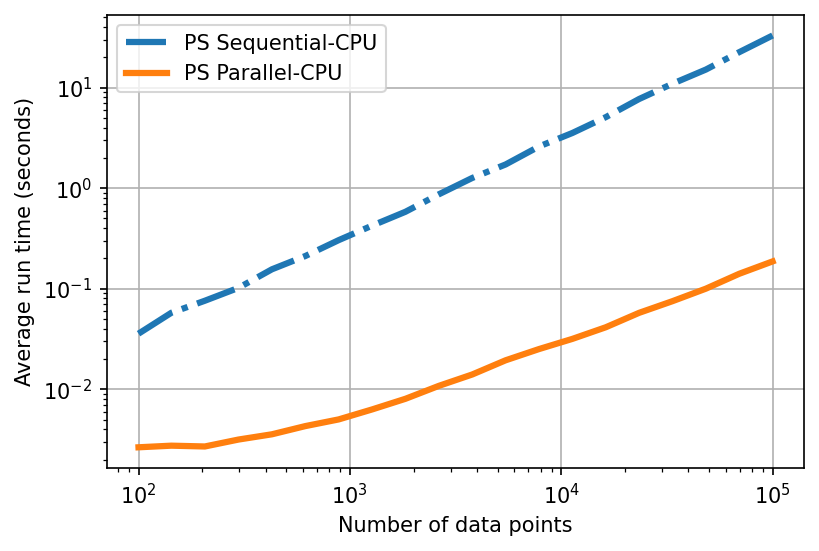

In [41]:
fig = plt.figure(1, dpi=150)

plt.loglog(input_sizes, cpu_sequential_runtimes, label="PS Sequential-CPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, cpu_parallel_runtimes, label="PS Parallel-CPU", linewidth=3)
plt.legend()
plt.xlabel("Number of data points")
plt.ylabel("Average run time (seconds)")
plt.grid()
plt.show()

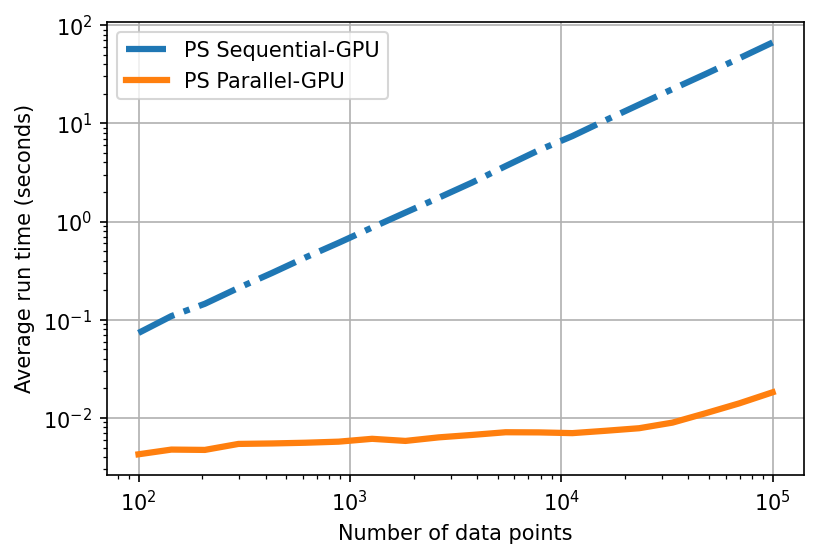

In [42]:
fig = plt.figure(1, dpi=150)
plt.loglog(input_sizes, xpu_sequential_runtimes, label="PS Sequential-GPU", linestyle="-.", linewidth=3)
plt.loglog(input_sizes, xpu_parallel_runtimes, label="PS Parallel-GPU", linewidth=3)
plt.legend()
plt.xlabel("Number of data points")
plt.ylabel("Average run time (seconds)")
plt.grid()
plt.show()